## Plot time series of SEA-POL low-level rain rate
From Level4v1.1 PICCOLO_level4_rainrate_2D.nc

In [40]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.transforms as transforms
from matplotlib.lines import Line2D
#import cmweather
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Define color-blind safe colors
cb_orange = [230/255, 159/255, 0]
cb_skyblue = [86/255, 180/255, 233/255]
cb_green = [0, 158/255, 115/255]
cb_yellow = [240/255, 228/255, 66/255]
cb_blue = [0, 114/255, 178/255]
cb_red = [213/255, 94/255, 0]
cb_purple = [204/255, 121/255, 167/255]


In [38]:
# helper function for skinny box plots
def _q_stats(data):
    vals = np.array([v for v in data if not np.isnan(v)])
    if vals.size == 0:
        return np.nan, np.nan, np.nan, np.nan
    q1, q2, q3 = np.nanpercentile(vals, [25, 50, 75])
    mean = np.nanmean(vals)
    return q1, q2, q3, mean

In [16]:
# code for weighted mean hourly block average
standard_time_grid = pd.date_range(np.datetime64('2024-08-16T08:00:00'), np.datetime64('2024-09-23T16:50:00'), freq='1 min')
def weighted_hourly_mean(values, sample_indices=None, minute_index=standard_time_grid):
    """
    Compute time-weighted hourly block means for irregularly spaced samples by
    mapping each sample to the minute-resolution grid and then taking
    the per-hour average (weights = number of minutes).
    
    Function written by Sarah Kennison
    
    Parameters:
    - values: 1D array of sample values (example: list of P or I)
    - sample_indices: list/array of integer indices into minute_index where values are located
    - minute_index: numpy.datetime64[minute] array or list of minute timestamps (standard_time_grid)
    Returns
    - pandas.Series indexed by hourly timestamps with the time-weighted hourly means (NaN when no data)
    """    
    # convert masked arrays to regular numpy array with nans
    if hasattr(values, "mask"):
        # numpy.ma masked array
        vals = np.array(values.filled(np.nan), dtype=float)
    else:
        vals = np.array(values, dtype=float)
    dt_index = pd.to_datetime(minute_index)
    if sample_indices is not None:
        # create per-minute series, set values at sample indices, then forward-fill
        s = pd.Series(index=dt_index, data=np.nan, dtype=float)
        # bounds-check sample_indices and vals length
        if len(vals) != len(sample_indices):
            raise ValueError("When providing sample_indices, length of values must equal length of sample_indices.")
        s.iloc[sample_indices] = vals
        # forward-fill so each sample value applies until the next sample
        s = s.ffill()
    else:
        # assume vals already correspond to each minute in minute_index
        if len(vals) != len(dt_index):
            raise ValueError("values length must equal minute_index length when sample_indices is None.")
        s = pd.Series(index=dt_index, data=vals, dtype=float)
    # resample to hourly using the minute counts as weights (mean over minutes = time-weighted)
    hourly = s.resample('1H', label='left', closed='left').mean()
    return hourly

### Read in SEA-POL data

In [22]:
seapol = xr.open_dataset('../../data/SEA-POL_4v1.0_rainrate_2D_spatial_means_masked_reg10.nc')
seapol

<xarray.Dataset> Size: 707kB
Dimensions:       (time: 5526)
Coordinates:
  * time          (time) datetime64[ns] 44kB 2024-08-16T08:00:00 ... 2024-09-...
Data variables: (12/15)
    rain245_mean  (time) float64 44kB ...
    rain120_mean  (time) float64 44kB ...
    rain60_mean   (time) float64 44kB ...
    rain12_mean   (time) float64 44kB ...
    rain1_mean    (time) float64 44kB ...
    rain245_int   (time) float64 44kB ...
    ...            ...
    rain1_int     (time) float64 44kB ...
    rain245_frac  (time) float64 44kB ...
    rain120_frac  (time) float64 44kB ...
    rain60_frac   (time) float64 44kB ...
    rain12_frac   (time) float64 44kB ...
    rain1_frac    (time) float64 44kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4b Gridded 2D Rain Rate
    units:        mm/h

### Read in IMERG and ERA_5 along track data. 

IMERG has been interpolated to a 0.25 degree grid and coarsened to hourly resolution. 

In [18]:
alongtrack = xr.open_dataset('../../data/IWVprecip_alongtrack.nc')
#precip_alongtrack_imerg
#precip_alongtrack_era5

### Coarsen SEA-POL to hourly block averages

### Plot multi-panel plot with hourly block average P, I, fa across different scales, plus panel with comparison to IMERG & ERA_5

/tmp/ipykernel_4076136/3895956930.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_4076136/3895956930.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_4076136/3895956930.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/tmp/ipykernel_4076136/3895956930.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/tmp/ipykernel_4076136/3895956930.py:56: UserWarning: set_ticklabels

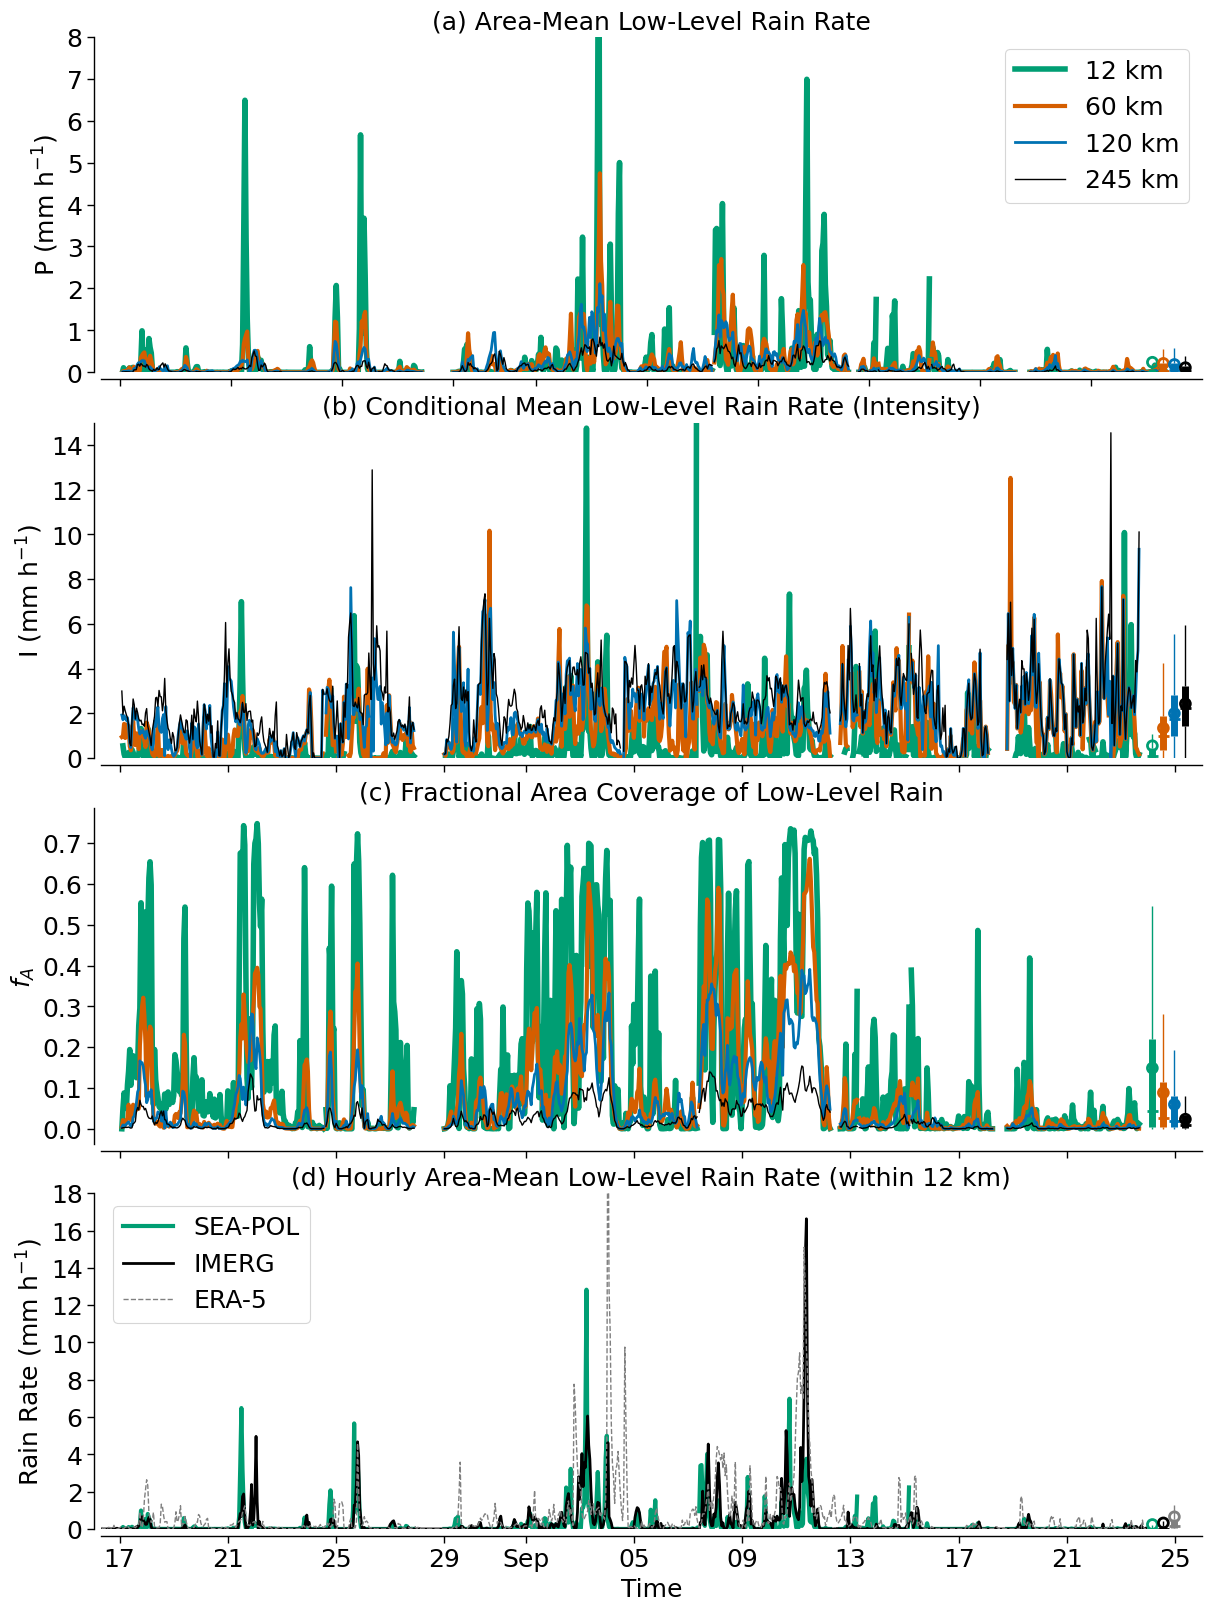

In [56]:
fig,axs = plt.subplots(4,1,figsize=(12,16),layout="constrained")

axs[0].plot(rain12_hrly.time, rain12_hrly, color=cb_green, label='12 km', linewidth=4)
axs[0].plot(rain60_hrly.time, rain60_hrly, color=cb_red, label='60 km', linewidth=3)
axs[0].plot(rain120_hrly.time, rain120_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[0].plot(rain245_hrly.time, rain245_hrly, color='black', label='245 km', linewidth=1)
axs[0].set_title('(a) Area-Mean Low-Level Rain Rate',fontsize=18)
axs[0].set_ylabel('P (mm h$^{-1}$)', fontsize=18)
#axs[0].set_xlabel('Time',fontsize=18)

sns.set_context('paper') 
sns.despine(offset=5)

axs[0].set_ylim(0,8)
axs[0].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 23:30'))

axs[0].legend(loc='upper right', fontsize=18)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

axs[0].set_xticklabels([])
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

axs[1].plot(rain12int_hrly.time, rain12int_hrly, color=cb_green, label='12 km', linewidth=4)
axs[1].plot(rain60int_hrly.time, rain60int_hrly, color=cb_red, label='60 km', linewidth=3)
axs[1].plot(rain120int_hrly.time, rain120int_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[1].plot(rain245int_hrly.time, rain245int_hrly, color='black', label='245 km', linewidth=1)
axs[1].set_title('(b) Conditional Mean Low-Level Rain Rate (Intensity)',fontsize=18)
axs[1].set_ylabel('I (mm h$^{-1}$)', fontsize=18)
#axs[1].set_xlabel('Time',fontsize=18)

axs[1].set_ylim(0,15)
axs[1].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-25 23:30'))

#axs[1].legend(loc='upper left', fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

axs[1].set_xticklabels([])
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)

axs[2].plot(rain12frac_hrly.time, rain12frac_hrly, color=cb_green, label='12 km', linewidth=4)
axs[2].plot(rain60frac_hrly.time, rain60frac_hrly, color=cb_red, label='60 km', linewidth=3)
axs[2].plot(rain120frac_hrly.time, rain120frac_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[2].plot(rain245frac_hrly.time, rain245frac_hrly, color='black', label='245 km', linewidth=1)
axs[2].set_title('(c) Fractional Area Coverage of Low-Level Rain',fontsize=18)
axs[2].set_ylabel('$f_A$', fontsize=18)
#axs[2].set_xlabel('Time',fontsize=18)

#axs[2].set_ylim(0,25)
axs[2].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-25 23:30'))

#axs[2].legend(loc='upper left', fontsize=18)
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)
axs[2].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[2].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))

axs[2].set_xticklabels([])
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)

axs[3].plot(rain12_hrly.time, rain12_hrly, color=cb_green, label='SEA-POL', linewidth=3)
axs[3].plot(alongtrack.time, alongtrack.precip_alongtrack_imerg, color='black', label='IMERG', linewidth=2)
axs[3].plot(alongtrack.time, alongtrack.precip_alongtrack_era5, color='gray', label='ERA-5', linewidth=1, linestyle = '--')

axs[3].set_title('(d) Hourly Area-Mean Low-Level Rain Rate (within 12 km)',fontsize=18)
axs[3].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
axs[3].set_xlabel('Time',fontsize=18)

axs[3].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-25 23:30'))
axs[3].set_ylim(0,18)

axs[3].legend(loc='upper left', fontsize=18)
axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=18)
axs[3].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[3].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[3].xaxis.get_major_locator()))

axs[3].set_xticklabels(axs[3].get_xticklabels(), fontsize=18)
axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=18)

ax_P = axs[0]
ax_I = axs[1]
ax_fa = axs[2]
ax_comp = axs[3]

## plot whiskers/boxplots on each panel

plot_items = [(ax_P, rain12_hrly, cb_green),
              (ax_I, rain12int_hrly, cb_green),
              (ax_fa, rain12frac_hrly, cb_green),
              (ax_comp, rain12_hrly, cb_green)]

for ax, data_list, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.955 #move a bit closer to the right edge
    dx_frac = 0.005 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=dot_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=dot_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               edgecolor=dot_color, facecolor='none', s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=dot_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=dot_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)

# plot next set of box plots
plot_items = [(ax_P, rain60_hrly, cb_red),
              (ax_I, rain60int_hrly, cb_red),
              (ax_fa, rain60frac_hrly, cb_red),
              (ax_comp, alongtrack.precip_alongtrack_imerg, 'black')]

for ax, data_list, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.965 #move a bit closer to the right edge
    dx_frac = 0.005 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=dot_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=dot_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               edgecolor=dot_color, facecolor='none', s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=dot_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=dot_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)

# plot next set of box plots
plot_items = [(ax_P, rain120_hrly, cb_blue),
              (ax_I, rain120int_hrly, cb_blue),
              (ax_fa, rain120frac_hrly, cb_blue),
              (ax_comp, alongtrack.precip_alongtrack_era5, 'gray')]

for ax, data_list, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.975 #move a bit closer to the right edge
    dx_frac = 0.005 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=dot_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=dot_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               edgecolor=dot_color, facecolor='none', s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=dot_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=dot_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line)
    
    # plot next set of box plots
plot_items = [(ax_P, rain245_hrly, 'black'),
              (ax_I, rain245int_hrly, 'black'),
              (ax_fa, rain245frac_hrly, 'black')]

for ax, data_list, dot_color in plot_items:
    q1, q2, q3, mean_val = _q_stats(data_list)
    if np.isnan(q1):
        continue
    xpos_frac = 0.985 #move a bit closer to the right edge
    dx_frac = 0.005 #horizontal half-width
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    
    # central IQR bar
    iqr_line = Line2D([xpos_frac, xpos_frac], [q1, q3],
                      transform=trans, color=dot_color,
                      linewidth=5, solid_capstyle='butt', zorder=4)
    ax.add_line(iqr_line)
    # median horizontal bar
    med_line = Line2D([xpos_frac - dx_frac, xpos_frac + dx_frac], [q2, q2],
                      transform=trans, color=dot_color,
                      linewidth=2, solid_capstyle='butt', zorder=5)
    ax.add_line(med_line)
    # mean marker circle
    ax.scatter([xpos_frac + dx_frac * .045], [mean_val], transform=trans,
               edgecolor=dot_color, facecolor='none', s=50,
               linewidths=2, zorder=6)
    # whiskers at 1.5 * IQR
    iqr = q3 - q1
    data_vals = np.array([v for v in data_list if not np.isnan(v)])
    if data_vals.size == 0:
        continue
    whisker_low = max(q1 - 1.5 * iqr, data_vals.min())
    whisker_high = min(q3 + 1.5 * iqr, data_vals.max())
    # whisker lines
    whisk_low_line = Line2D([xpos_frac, xpos_frac], [q1, whisker_low],
                            transform=trans, color=dot_color,
                            linewidth=1, solid_capstyle='butt', zorder=3)
    whisk_high_line = Line2D([xpos_frac, xpos_frac], [q3, whisker_high],
                             transform=trans, color=dot_color,
                             linewidth=1, solid_capstyle='butt', zorder=3)
    ax.add_line(whisk_low_line)
    ax.add_line(whisk_high_line) 
 
plt.savefig('../../figures/Fig_precip_timeseries_hrly.png')

### OLDER PLOTS

Plot area-mean precip & precip intensity time series

/tmp/ipykernel_4076136/2310677989.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_4076136/2310677989.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_4076136/2310677989.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/tmp/ipykernel_4076136/2310677989.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=18)
/tmp/ipykernel_4076136/2310677989.py:43: UserWarning: set_ticklabels

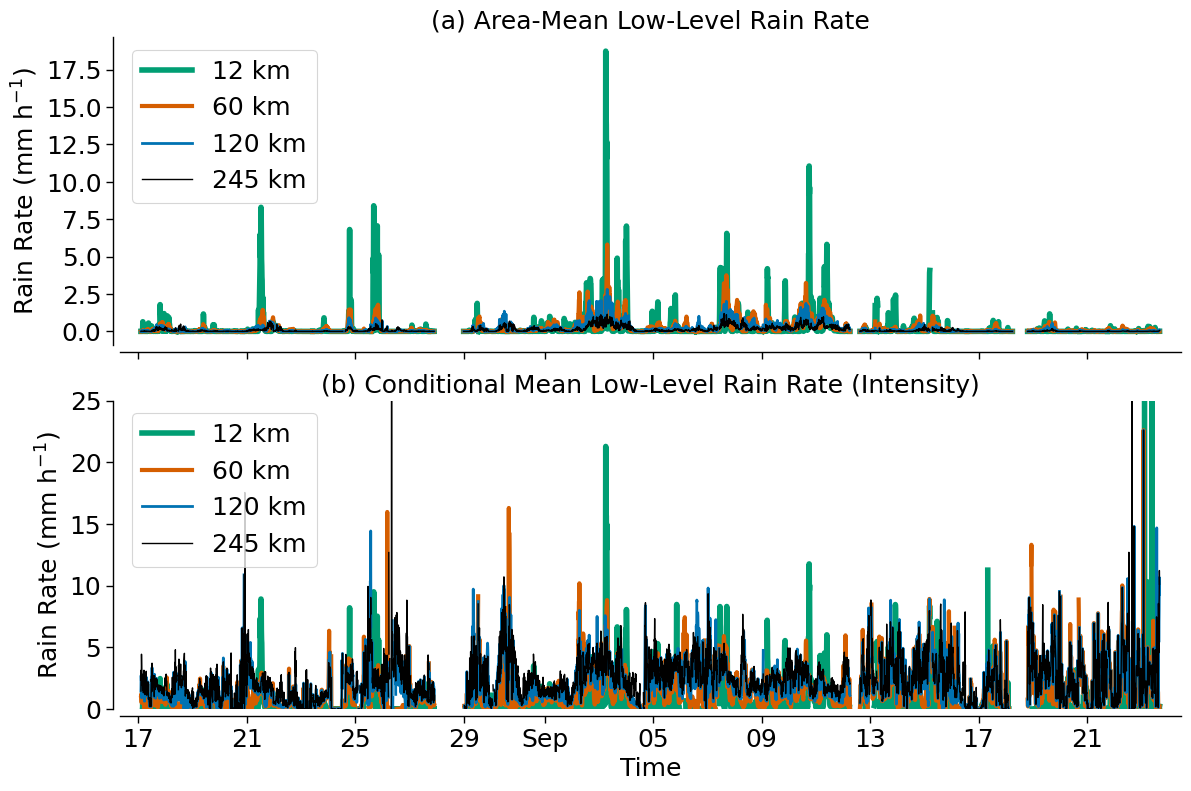

In [23]:
#Plot for whole campaign (all data)

fig,axs = plt.subplots(2,1,figsize=(12,8),layout="constrained")

axs[0].plot(seapol.time, seapol.rain12_mean, color=cb_green, label='12 km', linewidth=4)
axs[0].plot(seapol.time, seapol.rain60_mean, color=cb_red, label='60 km', linewidth=3)
axs[0].plot(seapol.time, seapol.rain120_mean, color=cb_blue, label='120 km', linewidth=2)
axs[0].plot(seapol.time, seapol.rain245_mean, color='black', label='245 km', linewidth=1)
axs[0].set_title('(a) Area-Mean Low-Level Rain Rate',fontsize=18)
axs[0].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
#axs[0].set_xlabel('Time',fontsize=18)

sns.set_context('paper') 
sns.despine(offset=5)

axs[0].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[0].legend(loc='upper left', fontsize=18)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

axs[0].set_xticklabels([])
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

axs[1].plot(seapol.time, seapol.rain12_int, color=cb_green, label='12 km', linewidth=4)
axs[1].plot(seapol.time, seapol.rain60_int, color=cb_red, label='60 km', linewidth=3)
axs[1].plot(seapol.time, seapol.rain120_int, color=cb_blue, label='120 km', linewidth=2)
axs[1].plot(seapol.time, seapol.rain245_int, color='black', label='245 km', linewidth=1)
axs[1].set_title('(b) Conditional Mean Low-Level Rain Rate (Intensity)',fontsize=18)
axs[1].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
axs[1].set_xlabel('Time',fontsize=18)

axs[1].set_ylim(0,25)
axs[1].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[1].legend(loc='upper left', fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)

plt.tight_layout() 

In [24]:
#Find where intensity greater than 25
rain245int_gt25 = np.where(seapol.rain245_int > 25)[0]
print('rain245int > 25:',seapol.rain245_int[rain245int_gt25].values)
print('rain245int > 25 times:',seapol.time[rain245int_gt25].values)

rain120int_gt25 = np.where(seapol.rain120_int > 25)[0]
print('rain120int > 25:',seapol.rain120_int[rain120int_gt25].values)
print('rain120int > 25 times:',seapol.time[rain120int_gt25].values)

rain60int_gt25 = np.where(seapol.rain60_int > 25)[0]
print('rain60int > 25:',seapol.rain60_int[rain60int_gt25].values)
print('rain60int > 25 times:',seapol.time[rain60int_gt25].values)


rain245int > 25: [42.50668716 54.20727539]
rain245int > 25 times: ['2024-08-26T08:10:00.000000000' '2024-09-22T15:50:00.000000000']
rain120int > 25: []
rain120int > 25 times: []
rain60int > 25: []
rain60int > 25 times: []


Coarsen SEA-POL data to hourly (block average)

In [25]:
ncoarsen = 6 # 6 10-minute intervals for 1 hour, 12 5-minute intervals for 1 hour

rain245_hrly = seapol.rain245_mean.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain120_hrly = seapol.rain120_mean.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain60_hrly = seapol.rain60_mean.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain12_hrly = seapol.rain12_mean.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain1_hrly = seapol.rain1_mean.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')

rain245int_hrly = seapol.rain245_int.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain120int_hrly = seapol.rain120_int.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain60int_hrly = seapol.rain60_int.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain12int_hrly = seapol.rain12_int.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain1int_hrly = seapol.rain1_int.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')

rain245frac_hrly = seapol.rain245_frac.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain120frac_hrly = seapol.rain120_frac.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain60frac_hrly = seapol.rain60_frac.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain12frac_hrly = seapol.rain12_frac.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')
rain1frac_hrly = seapol.rain1_frac.coarsen(time=ncoarsen,boundary='trim',coord_func={'time':'min'}).mean(skipna='true')

In [26]:
#find where intensity greater than 11 in hourly data
rain245int_hrly_gt11 = np.where(rain245int_hrly > 11)[0]
print('rain245int_hrly > 11:',rain245int_hrly[rain245int_hrly_gt11].values)
print('rain245int_hrly > 11 times:',rain245int_hrly.time[rain245int_hrly_gt11].values)

rain245int_hrly > 11: [12.88272071 14.54141017]
rain245int_hrly > 11 times: ['2024-08-26T08:00:00.000000000' '2024-09-22T15:00:00.000000000']


Plot

/tmp/ipykernel_4076136/1702063557.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_4076136/1702063557.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_4076136/1702063557.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_4076136/1702063557.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


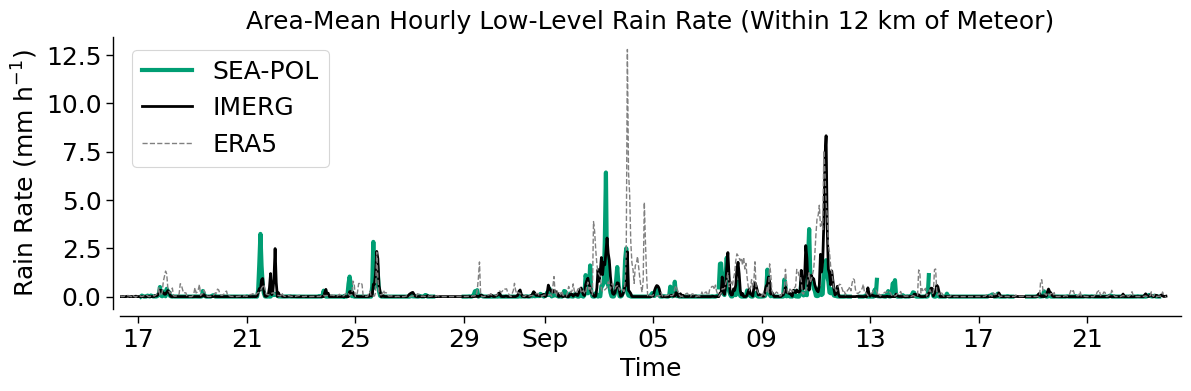

In [27]:
#Plot for whole campaign (hourly data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(rain12_hrly.time, rain12_hrly, color=cb_green, label='SEA-POL', linewidth=3)
ax.plot(alongtrack.time, alongtrack.precip_alongtrack_imerg, color='black', label='IMERG', linewidth=2)
ax.plot(alongtrack.time, alongtrack.precip_alongtrack_era5, color='gray', label='ERA5', linewidth=1, linestyle = '--')

sns.set_context('paper') 
sns.despine(offset=5)

ax.set_title('Area-Mean Hourly Low-Level Rain Rate (Within 12 km of Meteor)',fontsize=18)
ax.set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

ax.legend(loc='upper left', fontsize=18)
ax.set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

plt.tight_layout() 


/tmp/ipykernel_571743/3248481857.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_571743/3248481857.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_571743/3248481857.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/tmp/ipykernel_571743/3248481857.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/tmp/ipykernel_571743/3248481857.py:58: UserWarning: set_ticklabels() sh

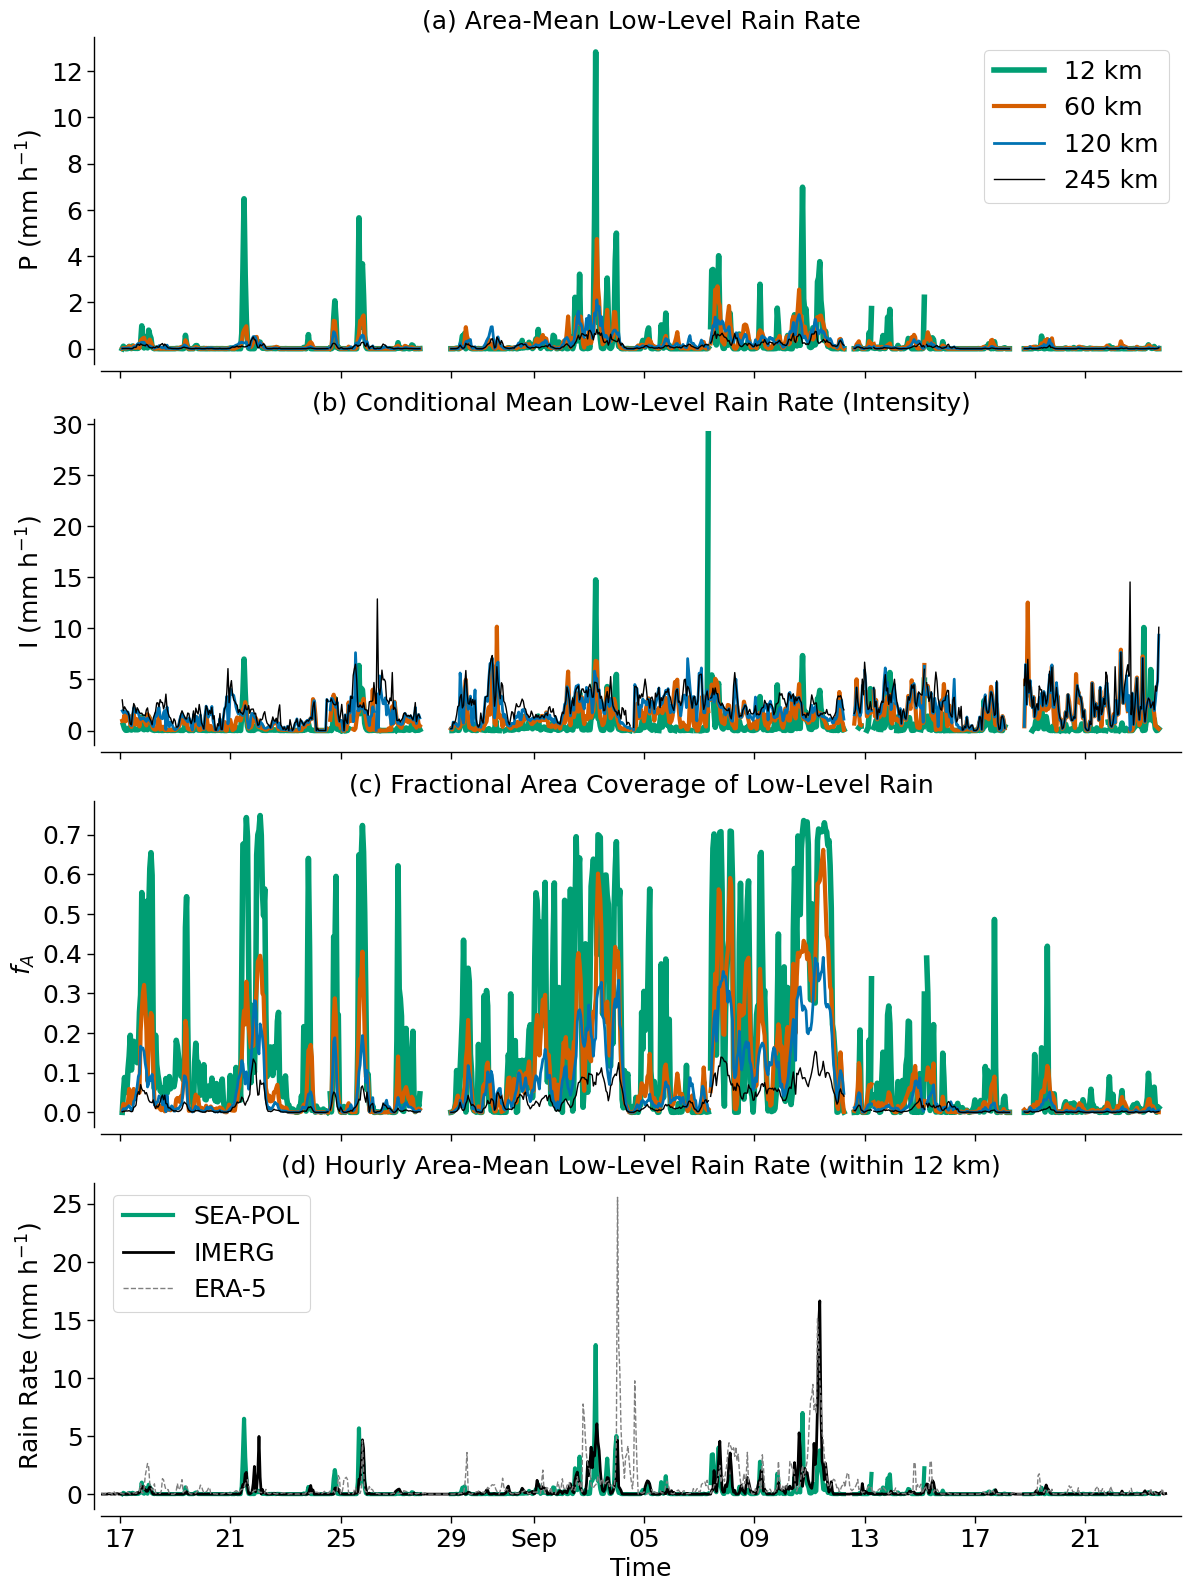

In [10]:
#Plot for whole campaign

fig,axs = plt.subplots(4,1,figsize=(12,16),layout="constrained")

axs[0].plot(rain12_hrly.time, rain12_hrly, color=cb_green, label='12 km', linewidth=4)
axs[0].plot(rain60_hrly.time, rain60_hrly, color=cb_red, label='60 km', linewidth=3)
axs[0].plot(rain120_hrly.time, rain120_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[0].plot(rain245_hrly.time, rain245_hrly, color='black', label='245 km', linewidth=1)
axs[0].set_title('(a) Area-Mean Low-Level Rain Rate',fontsize=18)
axs[0].set_ylabel('P (mm h$^{-1}$)', fontsize=18)
#axs[0].set_xlabel('Time',fontsize=18)

sns.set_context('paper') 
sns.despine(offset=5)

#axs[0].set_ylim(0,10)
axs[0].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[0].legend(loc='upper right', fontsize=18)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

axs[0].set_xticklabels([])
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

axs[1].plot(rain12int_hrly.time, rain12int_hrly, color=cb_green, label='12 km', linewidth=4)
axs[1].plot(rain60int_hrly.time, rain60int_hrly, color=cb_red, label='60 km', linewidth=3)
axs[1].plot(rain120int_hrly.time, rain120int_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[1].plot(rain245int_hrly.time, rain245int_hrly, color='black', label='245 km', linewidth=1)
axs[1].set_title('(b) Conditional Mean Low-Level Rain Rate (Intensity)',fontsize=18)
axs[1].set_ylabel('I (mm h$^{-1}$)', fontsize=18)
#axs[1].set_xlabel('Time',fontsize=18)

#axs[1].set_ylim(0,25)
axs[1].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

#axs[1].legend(loc='upper left', fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

axs[1].set_xticklabels([])
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)

axs[2].plot(rain12frac_hrly.time, rain12frac_hrly, color=cb_green, label='12 km', linewidth=4)
axs[2].plot(rain60frac_hrly.time, rain60frac_hrly, color=cb_red, label='60 km', linewidth=3)
axs[2].plot(rain120frac_hrly.time, rain120frac_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[2].plot(rain245frac_hrly.time, rain245frac_hrly, color='black', label='245 km', linewidth=1)
axs[2].set_title('(c) Fractional Area Coverage of Low-Level Rain',fontsize=18)
axs[2].set_ylabel('$f_A$', fontsize=18)
#axs[2].set_xlabel('Time',fontsize=18)

#axs[2].set_ylim(0,25)
axs[2].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

#axs[2].legend(loc='upper left', fontsize=18)
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)
axs[2].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[2].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))

axs[2].set_xticklabels([])
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)

axs[3].plot(rain12_hrly.time, rain12_hrly, color=cb_green, label='SEA-POL', linewidth=3)
axs[3].plot(alongtrack.time, alongtrack.precip_alongtrack_imerg, color='black', label='IMERG', linewidth=2)
axs[3].plot(alongtrack.time, alongtrack.precip_alongtrack_era5, color='gray', label='ERA-5', linewidth=1, linestyle = '--')

axs[3].set_title('(d) Hourly Area-Mean Low-Level Rain Rate (within 12 km)',fontsize=18)
axs[3].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
axs[3].set_xlabel('Time',fontsize=18)

axs[3].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[3].legend(loc='upper left', fontsize=18)
axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=18)
axs[3].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[3].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[3].xaxis.get_major_locator()))

axs[3].set_xticklabels(axs[3].get_xticklabels(), fontsize=18)
axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=18)

plt.tight_layout() 

plt.savefig('../../figures/Fig_precip_timeseries_hrlyfrom10.png')

In [28]:
#find where alongtrack.time is rain12_hrly.time[-1]
rain12_hrly_time = pd.to_datetime(rain12_hrly.time.values)
last_time = rain12_hrly_time[-1]
alongtrack_time = pd.to_datetime(alongtrack.time.values)
last_alongtrack_idx = np.where(alongtrack_time == last_time)[0][0]

/tmp/ipykernel_4076136/1465051337.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_4076136/1465051337.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_4076136/1465051337.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


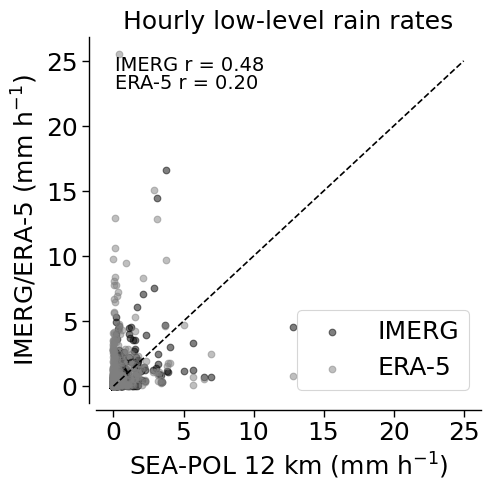

In [29]:
# Scatter plot of imerg and era-5 against rain12_hrly
fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
ax.scatter(rain12_hrly,alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1], color='black', label='IMERG', alpha=0.5)
ax.scatter(rain12_hrly,alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1], color='gray', label='ERA-5', alpha=0.5)

#plot 1:1 line
x = np.linspace(0, 25, 100)
ax.plot(x, x, color='black', linestyle='--')

#calculate correlation coefficient, ignoring nans
corr_imerg = np.corrcoef(rain12_hrly[~np.isnan(rain12_hrly)], alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1][~np.isnan(rain12_hrly)])[0, 1]
corr_era5 = np.corrcoef(rain12_hrly[~np.isnan(rain12_hrly)], alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1][~np.isnan(rain12_hrly)])[0, 1]
ax.text(0.05, 0.95, f'IMERG r = {corr_imerg:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
ax.text(0.05, 0.90, f'ERA-5 r = {corr_era5:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')

sns.set_context('paper') 
sns.despine(offset=5)

ax.set_ylabel('IMERG/ERA-5 (mm h$^{-1}$)', fontsize=18)
ax.set_xlabel('SEA-POL 12 km (mm h$^{-1}$)', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_title('Hourly low-level rain rates', fontsize=18)
ax.legend(fontsize=18)

plt.tight_layout() 

SEA-POL hourly running mean

In [30]:
# SEA-POL hourly running mean
rain12_hrly_run = seapol.rain12_mean.rolling(time=6, center=True).mean() # 6*10=60 minute running mean

/tmp/ipykernel_571743/1302499171.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


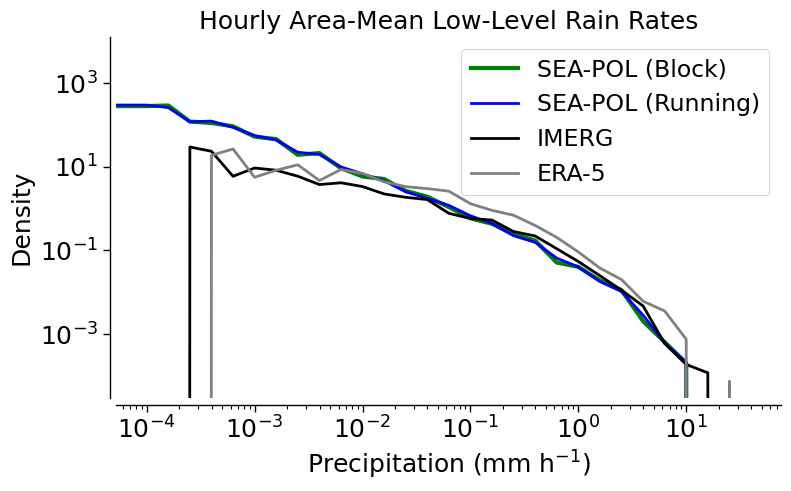

In [14]:
fig,ax = plt.subplots(figsize=(8,5),layout="constrained")

pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.2))))

## SEA-POL 12 km
phist_seapol12, bin_edges = np.histogram(rain12_hrly, bins=pbins, density=True)
phist_seapol12_run, bin_edges = np.histogram(rain12_hrly_run, bins=pbins, density=True)
phist_imerg, bin_edges = np.histogram(alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1], bins=pbins, density=True)
phist_era5, bin_edges = np.histogram(alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1], bins=pbins, density=True)

ax.plot(bin_edges[:-1], phist_seapol12, color='green', label='SEA-POL (Block)', linewidth=3)
ax.plot(bin_edges[:-1], phist_seapol12_run, color='blue', label='SEA-POL (Running)', linewidth=2)
ax.plot(bin_edges[:-1], phist_imerg, color='black', label='IMERG',linewidth=2)
ax.plot(bin_edges[:-1], phist_era5, color='gray', label='ERA-5',linewidth=2)

ax.set_title('Hourly Area-Mean Low-Level Rain Rates',fontsize=18)
ax.set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
ax.set_ylabel('Density',fontsize=18)
#ax.set_xlim(0,25)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=17, loc='upper right')
ax.tick_params(labelsize=18)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout() 

plt.savefig('../../figures/Fig_SEAPOL_IMERG_ERA5_pdf_hrlyfrom10.png')